# Sentiment Classification


### Generate Word Embeddings and retrieve outputs of each layer with Keras based on Classification task

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.

It is a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

We willl use the imdb dataset to learn word embeddings as we train our dataset. This dataset contains 25,000 movie reviews from IMDB, labeled with sentiment (positive or negative). 



### Dataset

`from keras.datasets import imdb`

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, the words are indexed by their frequency in the dataset, meaning the for that has index 1 is the most frequent word. Use the first 20 words from each review to speed up training, using a max vocab size of 10,000.

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.


### Aim

1. Import test and train data  
2. Import the labels ( train and test) 
3. Get the word index and then Create key value pair for word and word_id. (12.5 points)
4. Build a Sequential Model using Keras for Sentiment Classification task. (10 points)
5. Report the Accuracy of the model. (5 points)  
6. Retrive the output of each layer in keras for a given single test sample from the trained model you built. (2.5 points)


In [17]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import seaborn as sns
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
import time

#### Usage:

In [2]:
# current version of numpy have default allow_pickle as false so temporarily making it true to allow loading imdb dataset

# save np.load
np_load_old = np.load

# modify the default parameters of np.load. This makes load_data with allow_pickle implicitly set to true
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
vocab_size = 10000 #vocab size
maxlen = 300  #number of word used from each review

In [4]:
#load dataset as a list of ints
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

#make all sequences of the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test =  pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 6s 0us/step


In [5]:
# restore np.load for future normal usage
np.load = np_load_old

In [6]:
# checking the dataset shape
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (25000, 300)
y_train shape:  (25000,)
x_test shape:  (25000, 300)
y_test shape:  (25000,)


In [7]:
# checking first five review 
y_train[0:5]

array([1, 0, 0, 1, 0], dtype=int64)

## Build Keras Embedding Layer Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [ ]:
!mkdir model_checkpoints # folder for saving checkpoints
!mkdir models # folder for saving models for future use
!mkdir cnf # folder for saving models for future use

In [21]:
# utility fxn to plot model history and accuracy for each epoch
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# callback utility fxn for tensorboard, Initializing Early stopping and Model chekpoint callbacks**
# these fxn will be passed in model.fit 
def EarlyStopingModelCheckPoint():
    #tensorboard = TensorBoard(log_dir=".logs/{}".format(time.time()))

    #Adding Early stopping callback to the fit function is going to stop the training,
    #if the val_loss is not going to change even '0.001' for more than 5 continous epochs

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

    #Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
    # a new low value. Hence saving the best weights occurred during training

    model_checkpoint =  ModelCheckpoint('model_checkpoints/checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               mode='auto',
                                                               period=1)
    return early_stopping, model_checkpoint

review = ['Positive', 'Negative']

def plot_cnf_matrix(cnf_matrix, name):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
    ax.set_xticklabels(review)
    ax.set_yticklabels(review)
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    fig.savefig('cnf/{}.png'.format(name), dpi=300)
    plt.show();
    
def get1D_y_predict(y_pred):
    result = []
    for i in range(len(y_pred)):
        if(y_pred[i][0] > 0.50):
            result.append(1)
        else:
            result.append(0)
    return result

**Build model**

In [22]:
# define the model
model1 = Sequential()

# Embedding layer
model1.add(Embedding(vocab_size, 8, input_length=maxlen, name="embedding1"))

# Recurrent layer
model1.add(
    SimpleRNN(
        1, return_sequences=False, dropout=0.1, name="simple_rnn1"))

# Output layer: binary output
model1.add(Dense(1, activation='sigmoid', name="output"))

**Compile and review model**

In [23]:
# compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [24]:
# summarize the model
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding1 (Embedding)       (None, 300, 8)            80000     
_________________________________________________________________
simple_rnn1 (SimpleRNN)      (None, 1)                 10        
_________________________________________________________________
output (Dense)               (None, 1)                 2         
Total params: 80,012
Trainable params: 80,012
Non-trainable params: 0
_________________________________________________________________
None


**Train the model**

In [25]:
# fit the model
early_stopping,model_checkpoint = EarlyStopingModelCheckPoint()

history1 = model1.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64, # Number of observations per batch
                    verbose=1, # Print description after each epoch
                    callbacks=[early_stopping,model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 31s 1ms/step - loss: 0.6890 - acc: 0.5336 - val_loss: 0.6828 - val_acc: 0.5580

Epoch 00001: val_loss improved from inf to 0.68284, saving model to model_checkpoints/checkpoint_01_loss0.6828.h5
Epoch 2/50
25000/25000 [==============================] - 25s 981us/step - loss: 0.6575 - acc: 0.6180 - val_loss: 0.6782 - val_acc: 0.5639

Epoch 00002: val_loss improved from 0.68284 to 0.67819, saving model to model_checkpoints/checkpoint_02_loss0.6782.h5
Epoch 3/50
25000/25000 [==============================] - 22s 892us/step - loss: 0.6175 - acc: 0.6709 - val_loss: 0.6939 - val_acc: 0.5670

Epoch 00003: val_loss did not improve from 0.67819
Epoch 4/50
25000/25000 [==============================] - 20s 809us/step - loss: 0.5878 - acc: 0.6984 - val_loss: 0.7147 - val_acc: 0.5626

Epoch 00004: val_loss did not improve from 0.67819
Epoch 5/50

**Model history and get model accuracy on test data**

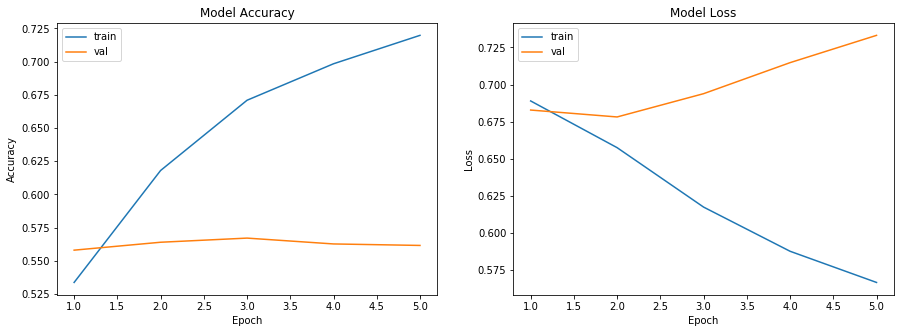

In [26]:
# plot model history
plot_model_history(history1)

In [27]:
# compute accuracy for validation dataset
val_loss1, val_acc1 = model1.evaluate(x_test, y_test, verbose=1)
print('\nExperiment1: Accuracy: %0.2f' %(val_acc1*100))

25000/25000 [==============================] - 9s 341us/step

Experiment1: Accuracy: 56.15


In [28]:
# predict test data and get classification report
y_pred1 = model1.predict(x_test)
ypred1 = get1D_y_predict(y_pred1)

# classification report with model acciracy and F1 score
cr1 = metrics.classification_report(y_test,ypred1)
print("Classification Report: \n\n", cr1)

Classification Report: 

               precision    recall  f1-score   support

           0       0.56      0.57      0.57     12500
           1       0.56      0.55      0.56     12500

   micro avg       0.56      0.56      0.56     25000
   macro avg       0.56      0.56      0.56     25000
weighted avg       0.56      0.56      0.56     25000



In [29]:
# Save model and weights for future use. 
model1.save('models/exp1_model.h5')
model1.save_weights('exp1_weights.h5')

**Experiment-2: Add more dense layer and customized optimizer with slower learning rate**

In [30]:
# define the model
model2 = Sequential()

# Embedding layer
model2.add(Embedding(vocab_size, 8, input_length=maxlen, name="embedding1"))

# Recurrent layer
model2.add(
    SimpleRNN(
        1, return_sequences=False, dropout=0.1, name="simple_rnn1"))

# Fully connected layer
model2.add(Dense(16, activation='relu', name="fc1"))

# Dropout for regularization
model2.add(Dropout(0.3, name="fc1_dropout"))

# Output layer: binary output
model2.add(Dense(1, activation='sigmoid', name="output"))

In [31]:
# creat customize optimizer with slower learning rate
optimizer = keras.optimizers.Adam(lr=0.001)

# compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

# summarize the model
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding1 (Embedding)       (None, 300, 8)            80000     
_________________________________________________________________
simple_rnn1 (SimpleRNN)      (None, 1)                 10        
_________________________________________________________________
fc1 (Dense)                  (None, 16)                32        
_________________________________________________________________
fc1_dropout (Dropout)        (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 80,059
Trainable params: 80,059
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# fit the model
early_stopping,model_checkpoint = EarlyStopingModelCheckPoint()

history2 = model2.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64, # Number of observations per batch
                    verbose=1, # Print description after each epoch
                    callbacks=[early_stopping,model_checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 22s 861us/step - loss: 0.5646 - acc: 0.7416 - val_loss: 0.5415 - val_acc: 0.7288

Epoch 00001: val_loss improved from inf to 0.54155, saving model to model_checkpoints/checkpoint_01_loss0.5415.h5
Epoch 2/50
25000/25000 [==============================] - 20s 800us/step - loss: 0.4585 - acc: 0.8058 - val_loss: 0.4424 - val_acc: 0.8087

Epoch 00002: val_loss improved from 0.54155 to 0.44245, saving model to model_checkpoints/checkpoint_02_loss0.4424.h5
Epoch 3/50
25000/25000 [==============================] - 20s 799us/step - loss: 0.4084 - acc: 0.8402 - val_loss: 0.4402 - val_acc: 0.8134

Epoch 00003: val_loss improved from 0.44245 to 0.44019, saving model to model_checkpoints/checkpoint_03_loss0.4402.h5
Epoch 4/50
25000/25000 [==============================] - 20s 809us/step - loss: 0.3828 - acc: 0.8562 - val_loss: 0.4719 - val_acc: 0.7985

Epoch 00004: val_loss did not improve fr

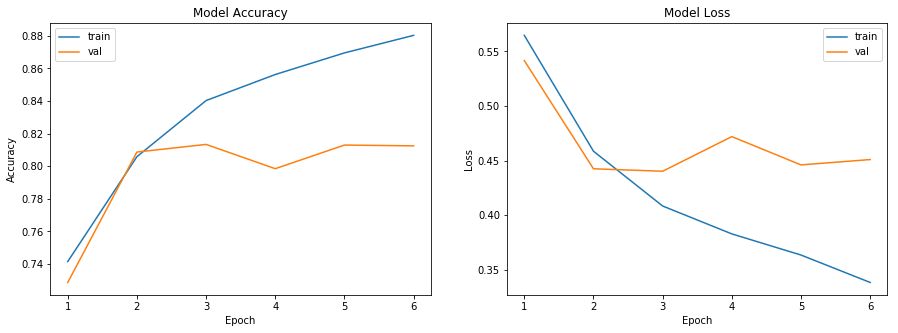

In [33]:
# plot model history
plot_model_history(history2)

In [34]:
# compute accuracy for validation dataset
val_loss2, val_acc2 = model2.evaluate(x_test, y_test, verbose=1)
print('\nExperiment2: Test Accuracy: %0.2f' %(val_acc2*100))

25000/25000 [==============================] - 9s 347us/step

Experiment2: Test Accuracy: 81.25


In [35]:
# predict test data and get classification report
y_pred2 = model2.predict(x_test)
ypred2 = get1D_y_predict(y_pred2)

# classification report with model acciracy and F1 score
cr2 = metrics.classification_report(y_test,ypred2)
print("Classification Report: \n\n", cr2)

Classification Report: 

               precision    recall  f1-score   support

           0       0.82      0.80      0.81     12500
           1       0.80      0.83      0.82     12500

   micro avg       0.81      0.81      0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [36]:
# Save model and weights for future use. 
model2.save('models/exp2_model.h5')
model2.save_weights('exp2_weights.h5')

**Experiment-3: model build using LSTM recurrent layer**

In [37]:
# define the model
model3 = Sequential()

# Embedding layer
model3.add(Embedding(vocab_size, 8, input_length=maxlen, name="embedding1"))

# Recurrent layer
model3.add(
    LSTM(
        64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1, name="lstm1"))

# Fully connected layer
model3.add(Dense(16, activation='relu', name="fc1"))

# Dropout for regularization
model3.add(Dropout(0.3, name="fc1_dropout"))

# Output layer: binary output
model3.add(Dense(1, activation='sigmoid', name="output"))

In [38]:
# creat customize optimizer with slower learning rate
optimizer = keras.optimizers.Adam(lr=0.001)

# compile the model
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

# summarize the model
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding1 (Embedding)       (None, 300, 8)            80000     
_________________________________________________________________
lstm1 (LSTM)                 (None, 64)                18688     
_________________________________________________________________
fc1 (Dense)                  (None, 16)                1040      
_________________________________________________________________
fc1_dropout (Dropout)        (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 99,745
Trainable params: 99,745
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# fit the model
early_stopping,model_checkpoint = EarlyStopingModelCheckPoint()

history3 = model3.fit(x_train, y_train, 
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=64, # Number of observations per batch
                    verbose=1, # Print description after each epoch
                    callbacks=[early_stopping,model_checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 116s 5ms/step - loss: 0.5311 - acc: 0.7252 - val_loss: 0.3591 - val_acc: 0.8438

Epoch 00001: val_loss improved from inf to 0.35906, saving model to model_checkpoints/checkpoint_01_loss0.3591.h5
Epoch 2/50
25000/25000 [==============================] - 116s 5ms/step - loss: 0.3748 - acc: 0.8465 - val_loss: 0.3859 - val_acc: 0.8428

Epoch 00002: val_loss did not improve from 0.35906
Epoch 3/50
25000/25000 [==============================] - 112s 4ms/step - loss: 0.3031 - acc: 0.8816 - val_loss: 0.3793 - val_acc: 0.8339

Epoch 00003: val_loss did not improve from 0.35906
Epoch 4/50
25000/25000 [==============================] - 116s 5ms/step - loss: 0.2764 - acc: 0.8947 - val_loss: 0.3498 - val_acc: 0.8608

Epoch 00004: val_loss improved from 0.35906 to 0.34978, saving model to model_checkpoints/checkpoint_04_loss0.3498.h5
Epoch 5/50
25000/25000 [==============================] - 11

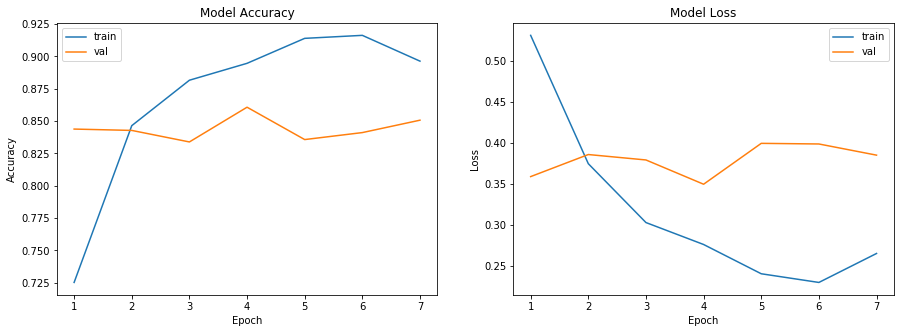

In [40]:
# plot model history
plot_model_history(history3)

In [41]:
# compute accuracy for validation dataset
val_loss3, val_acc3 = model3.evaluate(x_test, y_test, verbose=1)
print('\nExperiment3: Test Accuracy: %0.2f' %(val_acc3*100))

25000/25000 [==============================] - 28s 1ms/step

Experiment3: Test Accuracy: 85.07


In [42]:
# predict test data and get classification report
y_pred3 = model3.predict(x_test)
ypred3 = get1D_y_predict(y_pred3)

# classification report with model acciracy and F1 score
cr3 = metrics.classification_report(y_test,ypred3)
print("Classification Report: \n\n", cr3)

Classification Report: 

               precision    recall  f1-score   support

           0       0.84      0.87      0.85     12500
           1       0.86      0.84      0.85     12500

   micro avg       0.85      0.85      0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



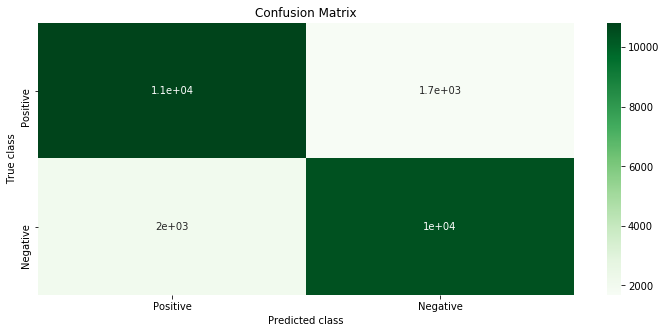

In [43]:
# confusion matrix
cm3 = metrics.confusion_matrix(y_test, ypred3)
plot_cnf_matrix(cm3, "exp3_cm")

In [44]:
# Save model and weights for future use. 
model3.save('models/exp3_model.h5')
model3.save_weights('exp3_weights.h5')

## Retrive the output of each layer in keras for a given single test sample from the trained model you built

**load best performing model from above experiment**

In [45]:
from keras.models import load_model
model = load_model('models/exp3_model.h5')

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding1 (Embedding)       (None, 300, 8)            80000     
_________________________________________________________________
lstm1 (LSTM)                 (None, 64)                18688     
_________________________________________________________________
fc1 (Dense)                  (None, 16)                1040      
_________________________________________________________________
fc1_dropout (Dropout)        (None, 16)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 99,745
Trainable params: 99,745
Non-trainable params: 0
_________________________________________________________________


**Retrieve output at each layer for test sample**

In [48]:
from keras import backend as K

inp = model.input                               # input placeholder
outputs = [layer.output for layer in model.layers ]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

In [49]:
# getting outpur at each layer for test sample

sample_pos = 100  # btw 0~24999
testSample = x_test[sample_pos][np.newaxis,...] # get the test sample

layer_outs = [func([testSample, 1.]) for func in functors] # get the output at each layer for the test sample

# print output at each layer
for idx, layer in enumerate(model.layers):
    print("\nLayer name: {}, Shape: {}: ".format(layer.name, layer_outs[idx][0][0].shape))
    print("Layer output")
    print(layer_outs[idx][0][0])


Layer name: embedding1, Shape: (300, 8): 
Layer output
[[ 0.01907749  0.01055368  0.03457913 ...  0.00992767 -0.02855216
   0.02300201]
 [ 0.01907749  0.01055368  0.03457913 ...  0.00992767 -0.02855216
   0.02300201]
 [ 0.01907749  0.01055368  0.03457913 ...  0.00992767 -0.02855216
   0.02300201]
 ...
 [-0.01807264  0.02866171 -0.00757257 ...  0.02067593 -0.02127077
  -0.00901937]
 [-0.02404241 -0.03193254 -0.01759193 ...  0.02636145 -0.04114711
  -0.0006753 ]
 [-0.0522507  -0.05518278  0.05018347 ... -0.03566875  0.01928688
   0.00322048]]

Layer name: lstm1, Shape: (64,): 
Layer output
[ 0.0330129  -0.15239277  0.00091012  0.02732288 -0.13891318  0.03920064
  0.04619582  0.05035656  0.38232875  0.00414391 -0.06531832 -0.13044599
  0.10238179  0.19178772  0.01635179  0.00392054  0.0811955  -0.02322188
  0.11789925 -0.00409287  0.0910548  -0.0025868   0.06890231 -0.08734596
 -0.06876145  0.0107867  -0.06083663 -0.04927991 -0.02753304 -0.02861942
 -0.28475857 -0.01226478  0.1872391  -0

### Experiment Analysis Report

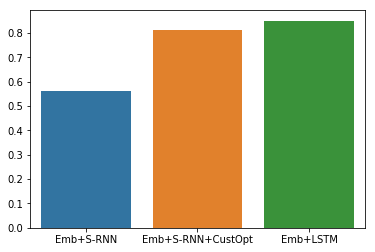

In [50]:
# comparing validation accuracy of all the experiments
models = ["Emb+S-RNN","Emb+S-RNN+CustOpt", "Emb+LSTM"]
model_acc = [val_acc1, val_acc2, val_acc3]
sns.barplot(x=models, y=model_acc)

**Experiment-1:**: Keras embedding layer model with Simple-RNN and dense layer with Adma optimizer
1. F1 Score: Negative: 57%, Positive: 56%
2. Validation accuracy: 56.15%
3. Train loss: loss: 0.5668 - train acc: 0.7198 - val_loss: 0.7331 - val_acc: 0.5615
4. Trainable params: 80,012

**Experiment-2:**: Above model is optimized further using customized adma optimizer with small learning rate of 0.001 and adding few Dense layer.
1. F1 Score: Negative: 81%, Positive: 82%
2. Accuracy: 81.25%
3. Train loss: loss: 0.3384 - train acc: 0.8802 - val_loss: 0.4509 - val_acc: 0.8125
4. Trainable params: 99,745

**Experiment-3:**: Keras embedding layer model with LSTN and dense layer with Adma optimizer.
1. F1 Score: Negative: 85%, Positive: 85%
2. Validation Accuracy: 85%
3. Train loss: 0.2655 - train acc: 0.8964 - val_loss: 0.3852 - val_acc: 0.8507
4. Trainable params: 99,745

Additionally, calssification report and confusion matrix are generated for comparing each model's precison, recall and F1 scored. Model using Embedding layer with LSTM shown better perfomance for model accuracy and F1 score.